# The Battle of Neighborhoods
### Applied Data Science Capstone

## Introduction

This proyect will find the best place for Mexicans to live in Toronto, Canada. Specifically, this report will be targeted to stakeholders interested in immigrating from Mexico City, Mexico  to Toronto, Canada.

Nowadays, there are quiet lots of Mexicans who try to immigrate to Canada for a variety of personal reasons, with intentions of settling, permanently or temporarily. This project try to find the locations that have similar facilities with Mexico City. 

This project could help Mexicans who want to immigrate to Canada by representing the most adaptable neighborhood in Toronto.

## Data

Based on definition of my problem, factors that will influenece our decission are:

1. Category and frequency of facilities in Mexico City and Downtown Toronto.
2. Similarity of existing facilities.

Following data sources will be needed to extract/generate the required information:

1. The information of Neighbourhood in Toronto, Canada including postal codes will be obtained from Wikipedia page. (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M).

2. The geographical coordinates of each postal code of Canada will be obtained from a csv file
(http://cocl.us/Geospatial_data).

3. Similarity of existing facilities in the neighborhood of Toronto and Mexico City will be obtained using Foursquare API

### Neighborhood Candidates

Let's create latitude and longitude coordinates for centroids of our candidate neighborhoods. A dataframe that includes info about Downtown Toronto Borough will be created. Lets find geograpical coordiates for Mexico City Borough.<br><br>
First, using Wikipedia page and csv file, lets maje a Dowontown Toronto Borough dataframe.

#### Importing libraries

In [1]:
#!pip install lxml html5lib beautifulsoup4
!pip install folium
#!pip install geocoder
#!conda install -c conda-forge geopy --yes

print("Install finished!")

import pandas as pd
import numpy as np

import folium

from geopy.geocoders import Nominatim

import requests

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans 

import json
import requests
from pandas.io.json import json_normalize
from sklearn import preprocessing

     |████████████████████████████████| 93 kB 2.8 MB/s  eta 0:00:01
Install finished!


#### DataFrame of Downtown Toronto in Toronto, Canada
By Web scraping and importing csv.file, make a dataframe `dt`.

In [2]:
# Web scraping
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs = pd.read_html(url)
df = dfs[0]

# Drop the row where the Borough is 'Not assigned'
idx_1 = df[df['Borough'] == 'Not assigned'].index
df = df.drop(idx_1)
df = df.reset_index(drop=True)
df.head()

# Change the neighbourhood 'Not assigned' into the same as the borough
idx_2 = df[df['Neighbourhood'] == 'Not assigned'].index
df.iloc[idx_2, 2] = df.iloc[idx_2,1]

# importing CSV file
path = 'https://cocl.us/Geospatial_data'
df_geo = pd.read_csv(path)
df_geo.head()

# Merge the Dataframe
df_merged = df
df_merged = df.join(df_geo.set_index('Postal Code'),
                   on = 'Postal Code')

df_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Make `dt` have only info for Borough "Downtown Toronto".

In [3]:
dt = df_merged[df_merged['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
print(dt.shape)
dt.head()

(19, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


#### Geographical coordinate of Mexico City, Mexico

In [21]:
address = 'Mexico City, Mexico'

geolocator = Nominatim(user_agent = "mexico_explorer")
s_location = geolocator.geocode(address)
s_latitude = s_location.latitude
s_longitude = s_location.longitude
print('The geograpical coordinate of Mexico City are {}, {}'.format(s_latitude, s_longitude))

The geograpical coordinate of Mexico City are 19.4326296, -99.1331785


### Foursquare
Now lets use Foursquare API to get info on facilities in Mexico and Toronto.

In [22]:
CLIENT_ID = 'MRKVYQVGVG4AKFNHV3WNG4DR5LWWXDAZPXPMCL5NKI4DEK52' 
CLIENT_SECRET = 'REOG0OR3NJ1FQMWE22KJMFUSMWEVDNRZXEHVBX1T5UIPSMSC' 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MRKVYQVGVG4AKFNHV3WNG4DR5LWWXDAZPXPMCL5NKI4DEK52
CLIENT_SECRET:REOG0OR3NJ1FQMWE22KJMFUSMWEVDNRZXEHVBX1T5UIPSMSC


#### Mexico City
First, we'll going to get the top 100 venues that are in Mexico City within a radius of 1000 meters.

In [23]:
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
CLIENT_ID, CLIENT_SECRET, VERSION, s_latitude, s_longitude, radius, LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?client_id=MRKVYQVGVG4AKFNHV3WNG4DR5LWWXDAZPXPMCL5NKI4DEK52&client_secret=REOG0OR3NJ1FQMWE22KJMFUSMWEVDNRZXEHVBX1T5UIPSMSC&v=20180605&ll=19.4326296,-99.1331785&radius=1000&limit=100'

In [24]:
results = requests.get(url).json()["response"]["groups"][0]['items']
results

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '4b058700f964a520827a22e3',
   'name': 'Catedral Metropolitana de la Asunción de María',
   'location': {'address': 'Plaza de la Constitución S/N',
    'lat': 19.433526472529614,
    'lng': -99.13320365052626,
    'distance': 99,
    'postalCode': '06000',
    'cc': 'MX',
    'city': 'Cuauhtemoc',
    'state': 'Distrito Federal',
    'country': 'México',
    'formattedAddress': ['Plaza de la Constitución S/N',
     '06000 Cuauhtémoc, Distrito Federal',
     'México']},
   'categories': [{'id': '4bf58dd8d48988d132941735',
     'name': 'Church',
     'pluralName': 'Churches',
     'shortName': 'Church',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/religious_church_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-4b058700f964a520827a

Lets append these information into a dataframe.

In [25]:
venues_list=[]
venues_list.append([(
    v['venue']['name'],
    v['venue']['location']['lat'],
    v['venue']['location']['lng'],
    v['venue']['categories'][0]['name']) for v in results])

sd_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
sd_venues.columns = ['Venue','Venue Latitude','Venue Longitude','Venue Category']

sd_venues.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Catedral Metropolitana de la Asunción de María,19.433526,-99.133204,Church
1,Centro Histórico,19.430786,-99.134095,Plaza
2,Plaza de la Constitución (Zócalo),19.432745,-99.133658,Plaza
3,Gran Hotel Ciudad de México,19.432137,-99.134468,Hotel
4,Palacio de Hierro,19.431112,-99.134147,Department Store


In [26]:
sd_venues.shape

(100, 4)

In [27]:
print('There are {} uniques categories.'.format(len(sd_venues['Venue Category'].unique())))

There are 53 uniques categories.


#### Downtown Toronto, Toronto
Now, we need to get the facilities info for Downtown Toronto using Foursquare API. Lets bring top 100 venues in Downtown Toronto within a radius of 1000 meters.

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

# function that makes dataframe
def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
        name,
        lat,
        lng,
        v['venue']['name'],
        v['venue']['location']['lat'],
        v['venue']['location']['lng'],
        v['venue']['categories'][0]['name']) for v in results])
        
    dt_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    dt_venues.columns = [
                            'Neighbourhood',
                            'Neighbourhood Latitude',
                            'Neighbourhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    
    return(dt_venues)

In [29]:
dt_venues = getNearbyVenues(names = dt['Neighbourhood'], latitudes = dt['Latitude'], longitudes = dt['Longitude'], radius = 1000)

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [30]:
print(dt_venues.shape)
dt_venues.head()

(1669, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site


## Methodology

This project I will direct efforts on detecting best areas of Downtown Toronto, Toronto that have similarity of the presence and frequency of facilities to Mexico City.

In first step, we have collected the required

Second step will be clustering Neighborhoods of Downtown Toronto using their Venue category and its frequency. Then we will use K-Means clustering model and one-hot encoding method for categorical variables clustering.

In third step, we will focus on categorizing the Mexico City. With cluster index of Downtown Toronto, using it as categorizing index, we are going to classify which cluster Mexico City belongs to. Using decision tree model and one-hot encoding method for categorical variables categorizing.

## Analysis

For generating explanatory data analysis and deriving additional info, lets pick top 10 categories that appears most. Let's figure the frequency out using one-hot encoding:

#### Mexico City

In [31]:
# one hot encoding
sd_onehot = pd.get_dummies(sd_venues[['Venue Category']], prefix="", prefix_sep="")

sd_onehot = sd_onehot.mean().reset_index()
sd_onehot.columns = ['category', 'freq']
sd_onehot = sd_onehot.sort_values('freq', ascending=False).reset_index(drop=True)
sd_onehot.head(10)

,category,freq
0,Mexican Restaurant,0.08
1,Art Museum,0.06
2,Museum,0.05
3,Ice Cream Shop,0.05
4,Hotel,0.04
5,Arts & Crafts Store,0.04
6,Coffee Shop,0.03
7,Historic Site,0.03
8,Café,0.03
9,Bookstore,0.03


Change it into a more recognizable form.

In [32]:
num_top_venues = 10
indicators = ['st','nd','rd']
columns = []
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
# Create a new dataframe
sd_venues_sorted = sd_onehot.T.reset_index()
sd_venues_sorted.drop('index', axis = 1, inplace=True)
sd_venues_sorted = sd_venues_sorted.iloc[:, np.arange(0,10)]

sd_venues_sorted.columns = columns
sd_venues_sorted

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mexican Restaurant,Art Museum,Museum,Ice Cream Shop,Hotel,Arts & Crafts Store,Coffee Shop,Historic Site,Café,Bookstore
1,0.08,0.06,0.05,0.05,0.04,0.04,0.03,0.03,0.03,0.03


We successfully extract top 10 Common Venues Categories and their frequency of Mexico City.

#### Toronto
Now, we are going same analysis to get top 10 Common Venues of each Neighborhood in Toronto.

In [33]:
dt_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
4,"Regent Park, Harbourfront",43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site


In [34]:
dt_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,100,100,100,100,100,100
Christie,100,100,100,100,100,100
Church and Wellesley,100,100,100,100,100,100
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100


In [35]:
print('There are {} unique categories.'.format(len(dt_venues['Venue Category'].unique())))

There are 201 unique categories.


Analyze Each Neighbourhood

In [36]:
dt_temp = pd.get_dummies(dt_venues[['Venue Category']],prefix = '', prefix_sep='')

dt_temp['Neighbourhood'] = dt_venues['Neighbourhood']

fixed_columns = [dt_temp.columns[-1]]+list(dt_temp.columns[:-1])
dt_temp = dt_temp[fixed_columns]

dt_temp.head()

,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Theme Restaurant,Track,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
dt_temp.shape

(1669, 202)

In [38]:
dt_onehot = dt_temp.groupby('Neighbourhood').mean().reset_index()
dt_onehot

,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Theme Restaurant,Track,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,0.000000,...,0.00,0.000000,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.071429,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.00,0.071429,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Central Bay Street,0.000000,0.010000,0.00,0.00,0.02,0.01,0.01,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.02
3,Christie,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.00,0.02,0.00,0.01,0.01,0.00
4,Church and Wellesley,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,0.000000,...,0.01,0.000000,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02
5,"Commerce Court, Victoria Hotel",0.000000,0.020000,0.00,0.00,0.02,0.00,0.00,0.01,0.000000,...,0.00,0.000000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00
6,"First Canadian Place, Underground city",0.000000,0.020000,0.00,0.00,0.01,0.00,0.00,0.01,0.000000,...,0.00,0.000000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00
7,"Garden District, Ryerson",0.000000,0.010000,0.00,0.00,0.00,0.01,0.00,0.00,0.000000,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
8,"Harbourfront East, Union Station, Toronto Islands",0.000000,0.000000,0.00,0.02,0.01,0.00,0.00,0.01,0.000000,...,0.00,0.010000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.01
9,"Kensington Market, Chinatown, Grange Park",0.000000,0.000000,0.00,0.00,0.03,0.00,0.01,0.00,0.000000,...,0.00,0.000000,0.00,0.01,0.01,0.05,0.00,0.02,0.01,0.03


In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
dt_venues_sorted = pd.DataFrame(columns = columns)
dt_venues_sorted['Neighbourhood'] = dt_onehot['Neighbourhood']

for ind in np.arange(dt_onehot.shape[0]):
    dt_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dt_onehot.iloc[ind, :], num_top_venues)
    
dt_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Café,Japanese Restaurant,Hotel,Beer Bar,Park,Restaurant,Gastropub,Liquor Store,Grocery Store
1,"CN Tower, King and Spadina, Railway Lands, Har...",Coffee Shop,Harbor / Marina,Café,Airport,Garden,Park,Dog Run,Scenic Lookout,Sculpture Garden,Dance Studio
2,Central Bay Street,Coffee Shop,Sushi Restaurant,Café,Japanese Restaurant,Ramen Restaurant,Park,Cosmetics Shop,Breakfast Spot,Bubble Tea Shop,Plaza
3,Christie,Korean Restaurant,Coffee Shop,Café,Grocery Store,Cocktail Bar,Mexican Restaurant,Ice Cream Shop,Bar,Park,Comedy Club
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Gay Bar,Park,Men's Store,Sushi Restaurant,Hotel,Ramen Restaurant,Pizza Place,Yoga Studio
5,"Commerce Court, Victoria Hotel",Coffee Shop,Hotel,Café,Restaurant,Gastropub,Beer Bar,Japanese Restaurant,Gym,Cocktail Bar,Cosmetics Shop
6,"First Canadian Place, Underground city",Coffee Shop,Hotel,Café,Restaurant,Japanese Restaurant,Gastropub,Theater,Concert Hall,Beer Bar,Italian Restaurant
7,"Garden District, Ryerson",Coffee Shop,Japanese Restaurant,Gastropub,Italian Restaurant,Restaurant,Diner,Bookstore,New American Restaurant,Creperie,Middle Eastern Restaurant
8,"Harbourfront East, Union Station, Toronto Islands",Coffee Shop,Café,Hotel,Restaurant,Park,Theater,Brewery,Gym,Scenic Lookout,Japanese Restaurant
9,"Kensington Market, Chinatown, Grange Park",Café,Bar,Vegetarian / Vegan Restaurant,Coffee Shop,Mexican Restaurant,Yoga Studio,Art Gallery,Record Shop,Bakery,Beer Bar


We have listed the 10 most common venues for the neighbourhood of downtown toronto.
Also, onehot encoding dataframe for both Mexico City and Downtown Toronto is ready.

### Cluster Neighbourhoods in Downtown Toronto
Let's cluster the neighbourhoods in Downtown Toronto. Variables for cluster are 10 most common venue categories. These are categorical values, so I have to use onehot encoding dataframe to cluster.

Using K-Means Clustering model, the number of clusters will be 5.

In [44]:
# number of clusters
kclusters = 5

dt_onehot_clustering = dt_onehot.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state = 0).fit(dt_onehot_clustering)

kmeans.labels_

array([1, 2, 0, 3, 0, 1, 1, 0, 1, 3, 0, 0, 1, 4, 1, 1, 1, 1, 3],
      dtype=int32)

In [45]:
# add clustering labels
dt_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
print(dt_venues_sorted.shape)
dt_venues_sorted.head()

ValueError: cannot insert Cluster Labels, already exists

In [46]:
dt_clustered = dt

dt_clustered = dt_clustered.join(dt_venues_sorted.set_index('Neighbourhood'),
                           on = 'Neighbourhood')
dt_clustered.dropna(inplace = True)
dt_clustered['Cluster Labels'] = dt_clustered['Cluster Labels'].astype(int)
print(dt_clustered.shape)
dt_clustered.head()

(19, 16)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Coffee Shop,Pub,Café,Park,Theater,Restaurant,Breakfast Spot,Diner,Bakery,Indian Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Coffee Shop,Park,Japanese Restaurant,Italian Restaurant,Café,Sushi Restaurant,Cosmetics Shop,Ramen Restaurant,Restaurant,Middle Eastern Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Coffee Shop,Japanese Restaurant,Gastropub,Italian Restaurant,Restaurant,Diner,Bookstore,New American Restaurant,Creperie,Middle Eastern Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Restaurant,Gastropub,Italian Restaurant,Hotel,Bakery,Beer Bar,Seafood Restaurant,Farmers Market
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Café,Japanese Restaurant,Hotel,Beer Bar,Park,Restaurant,Gastropub,Liquor Store,Grocery Store


Let's show this information on the map using folium.

In [47]:
# create map
t_address = 'Downtown Toronto, Toronto, Canada'

t_geolocator = Nominatim(user_agent = 'toronto_explorer')
t_location = geolocator.geocode(t_address)
t_latitude = t_location.latitude
t_longitude = t_location.longitude

map_clusters = folium.Map(location=[t_latitude, t_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters) # kclusters = 10
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dt_clustered['Latitude'], dt_clustered['Longitude'], dt_clustered['Neighbourhood'], dt_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Classify which cluster Mexico City belongs to.

Using decision Trees model, let's classify which cluster Mexico City belongs to among cluster 1-6. We will use onehot encoding dataframe for classification. Decision Tree classifier criterio will be 'entropy'.

In [48]:
sd_onehot_p = sd_onehot.T
sd_onehot_p.rename(columns = sd_onehot_p.iloc[0,:],inplace = True)
sd_onehot_p = sd_onehot_p.drop([sd_onehot_p.index[0]])
sd_onehot_p

,Mexican Restaurant,Art Museum,Museum,Ice Cream Shop,Hotel,Arts & Crafts Store,Coffee Shop,Historic Site,Café,Bookstore,...,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Deli / Bodega,Donut Shop,Falafel Restaurant,Frozen Yogurt Shop,General College & University,Theater
freq,0.08,0.06,0.05,0.05,0.04,0.04,0.03,0.03,0.03,0.03,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [49]:
dt_onehot_p = pd.DataFrame({'Cluster Labels': kmeans.labels_})
dt_onehot_p = pd.concat([dt_onehot_p, dt_onehot], axis = 1)
print(dt_onehot_p.shape)
dt_onehot_p

(19, 203)


,Cluster Labels,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Theme Restaurant,Track,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,1,Berczy Park,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,...,0.00,0.000000,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.00
1,2,"CN Tower, King and Spadina, Railway Lands, Har...",0.071429,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.071429,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,Central Bay Street,0.000000,0.010000,0.00,0.00,0.02,0.01,0.01,0.00,...,0.00,0.000000,0.00,0.00,0.01,0.02,0.00,0.00,0.01,0.02
3,3,Christie,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.02,0.00,0.01,0.01,0.00
4,0,Church and Wellesley,0.000000,0.010000,0.00,0.00,0.01,0.00,0.00,0.00,...,0.01,0.000000,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02
5,1,"Commerce Court, Victoria Hotel",0.000000,0.020000,0.00,0.00,0.02,0.00,0.00,0.01,...,0.00,0.000000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00
6,1,"First Canadian Place, Underground city",0.000000,0.020000,0.00,0.00,0.01,0.00,0.00,0.01,...,0.00,0.000000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00
7,0,"Garden District, Ryerson",0.000000,0.010000,0.00,0.00,0.00,0.01,0.00,0.00,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01
8,1,"Harbourfront East, Union Station, Toronto Islands",0.000000,0.000000,0.00,0.02,0.01,0.00,0.00,0.01,...,0.00,0.010000,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.01
9,3,"Kensington Market, Chinatown, Grange Park",0.000000,0.000000,0.00,0.00,0.03,0.00,0.01,0.00,...,0.00,0.000000,0.00,0.01,0.01,0.05,0.00,0.02,0.01,0.03


In [50]:
dt_onehot_p.columns[2:]

Index(['Airport', 'American Restaurant', 'Animal Shelter', 'Aquarium',
       'Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Asian Restaurant',
       'Athletics & Sports', 'Auto Dealership',
       ...
       'Theme Restaurant', 'Track', 'Train Station', 'Udon Restaurant',
       'University', 'Vegetarian / Vegan Restaurant', 'Video Store',
       'Vietnamese Restaurant', 'Wine Bar', 'Yoga Studio'],
      dtype='object', length=201)

In [51]:
for name in sd_onehot_p.columns:
    if name in dt_onehot_p.columns:
        None
    else:
        dt_onehot_p[name] = 0
print(dt_onehot_p.shape)
dt_onehot_p.head()

(19, 218)


,Cluster Labels,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Tattoo Parlor,General Entertainment,Indie Theater,Baseball Field,Beer Garden,Buffet,Church,Falafel Restaurant,Frozen Yogurt Shop,General College & University
0,1,Berczy Park,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,"CN Tower, King and Spadina, Railway Lands, Har...",0.071429,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,Central Bay Street,0.000000,0.01,0.0,0.0,0.02,0.01,0.01,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,Christie,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,Church and Wellesley,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0


Processing finished. For classification, Lets split the data into trainset and testset.

In [52]:
dt_X = dt_onehot_p[dt_onehot_p.columns[2:]].values
print(dt_X[0:5])
dt_y = dt_onehot_p['Cluster Labels']
print(dt_y[0:5])

[[0.         0.01       0.         ... 0.         0.         0.        ]
 [0.07142857 0.         0.         ... 0.         0.         0.        ]
 [0.         0.01       0.         ... 0.         0.         0.        ]
 [0.         0.01       0.         ... 0.         0.         0.        ]
 [0.         0.01       0.         ... 0.         0.         0.        ]]
0    1
1    2
2    0
3    3
4    0
Name: Cluster Labels, dtype: int32


In [53]:
from sklearn.model_selection import train_test_split

X_trainset, X_testset, y_trainset, y_testset = train_test_split(dt_X, dt_y, test_size=0.15, random_state=3)

print("Shape of X_trainset: ", X_trainset.shape)
print("Shape of y_trainset: ", y_trainset.shape)
print("Shape of X_testset: ", X_testset.shape)
print("Shape of y_testset: ", y_testset.shape)

Shape of X_trainset:  (16, 216)
Shape of y_trainset:  (16,)
Shape of X_testset:  (3, 216)
Shape of y_testset:  (3,)


In [54]:
from sklearn.tree import DecisionTreeClassifier

cTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
cTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [55]:
# Train the model

cTree.fit(X_trainset, y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [56]:
# Predict using the model

predTree_test = cTree.predict(X_testset)
print(predTree_test)
print(y_testset)

[3 0 4]
12    1
2     0
1     2
Name: Cluster Labels, dtype: int32


Let's evaluate the accuracy of decision tree model.

In [57]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTree's Accuracy: ", metrics.accuracy_score(y_testset, predTree_test))

DecisionTree's Accuracy:  0.3333333333333333


Models' accuracy is about 0.34. From now on, I will classify Mexico City.

In [58]:
sd_X = sd_onehot_p

for name in dt_onehot_p.columns[2:]:
    if name in sd_X.columns:
        None
    else:
        sd_X[name] = 0
sd_X

,Mexican Restaurant,Art Museum,Museum,Ice Cream Shop,Hotel,Arts & Crafts Store,Coffee Shop,Historic Site,Café,Bookstore,...,Theme Restaurant,Track,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
freq,0.08,0.06,0.05,0.05,0.04,0.04,0.03,0.03,0.03,0.03,...,0,0,0,0,0,0,0,0,0,0


In [59]:
predTree_sd = cTree.predict(sd_X)

In [61]:
print(predTree_sd)
print("Mexico City belongs to cluster {}.".format(predTree_sd[0]+1))

[3]
Mexico City belongs to cluster 4.


This concludes analysis.

In [71]:
print(dt_clustered[dt_clustered['Cluster Labels'] == 4]['Neighbourhood'].values)
dt_clustered[dt_clustered['Cluster Labels'] == 4]

['Rosedale']


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,4,Park,Coffee Shop,Grocery Store,Metro Station,Bank,Playground,Convenience Store,Sandwich Place,Filipino Restaurant,Candy Store


#### Visualization

In [63]:
!conda install pydotplus
#!conda install -c conda-forge python-graphviz -y
#!pip install six
print('Install finished')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pydotplus-2.0.2            |           py37_1          42 KB
    ------------------------------------------------------------
                                           Total:          42 KB

The following NEW packages will be INSTALLED:

  pydotplus          pkgs/main/linux-64::pydotplus-2.0.2-py37_1



pydotplus-2.0.2      | 42 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Install finished


In [64]:
from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline

In [72]:
dt_onehot_p.head()

,Cluster Labels,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Tattoo Parlor,General Entertainment,Indie Theater,Baseball Field,Beer Garden,Buffet,Church,Falafel Restaurant,Frozen Yogurt Shop,General College & University
0,1,Berczy Park,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2,"CN Tower, King and Spadina, Railway Lands, Har...",0.071429,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,Central Bay Street,0.000000,0.01,0.0,0.0,0.02,0.01,0.01,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,Christie,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,Church and Wellesley,0.000000,0.01,0.0,0.0,0.01,0.00,0.00,0.0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
sd_onehot_p.head()

,Mexican Restaurant,Art Museum,Museum,Ice Cream Shop,Hotel,Arts & Crafts Store,Coffee Shop,Historic Site,Café,Bookstore,...,Theme Restaurant,Track,Train Station,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
freq,0.08,0.06,0.05,0.05,0.04,0.04,0.03,0.03,0.03,0.03,...,0,0,0,0,0,0,0,0,0,0


In [75]:
dt_onehot_p[dt_onehot_p["Cluster Labels"] == 4]

,Cluster Labels,Neighbourhood,Airport,American Restaurant,Animal Shelter,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Tattoo Parlor,General Entertainment,Indie Theater,Baseball Field,Beer Garden,Buffet,Church,Falafel Restaurant,Frozen Yogurt Shop,General College & University
13,4,Rosedale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Let's Visualization the Decision tree.

In [76]:
y_trainset.unique()

array([1, 0, 3, 4], dtype=int32)

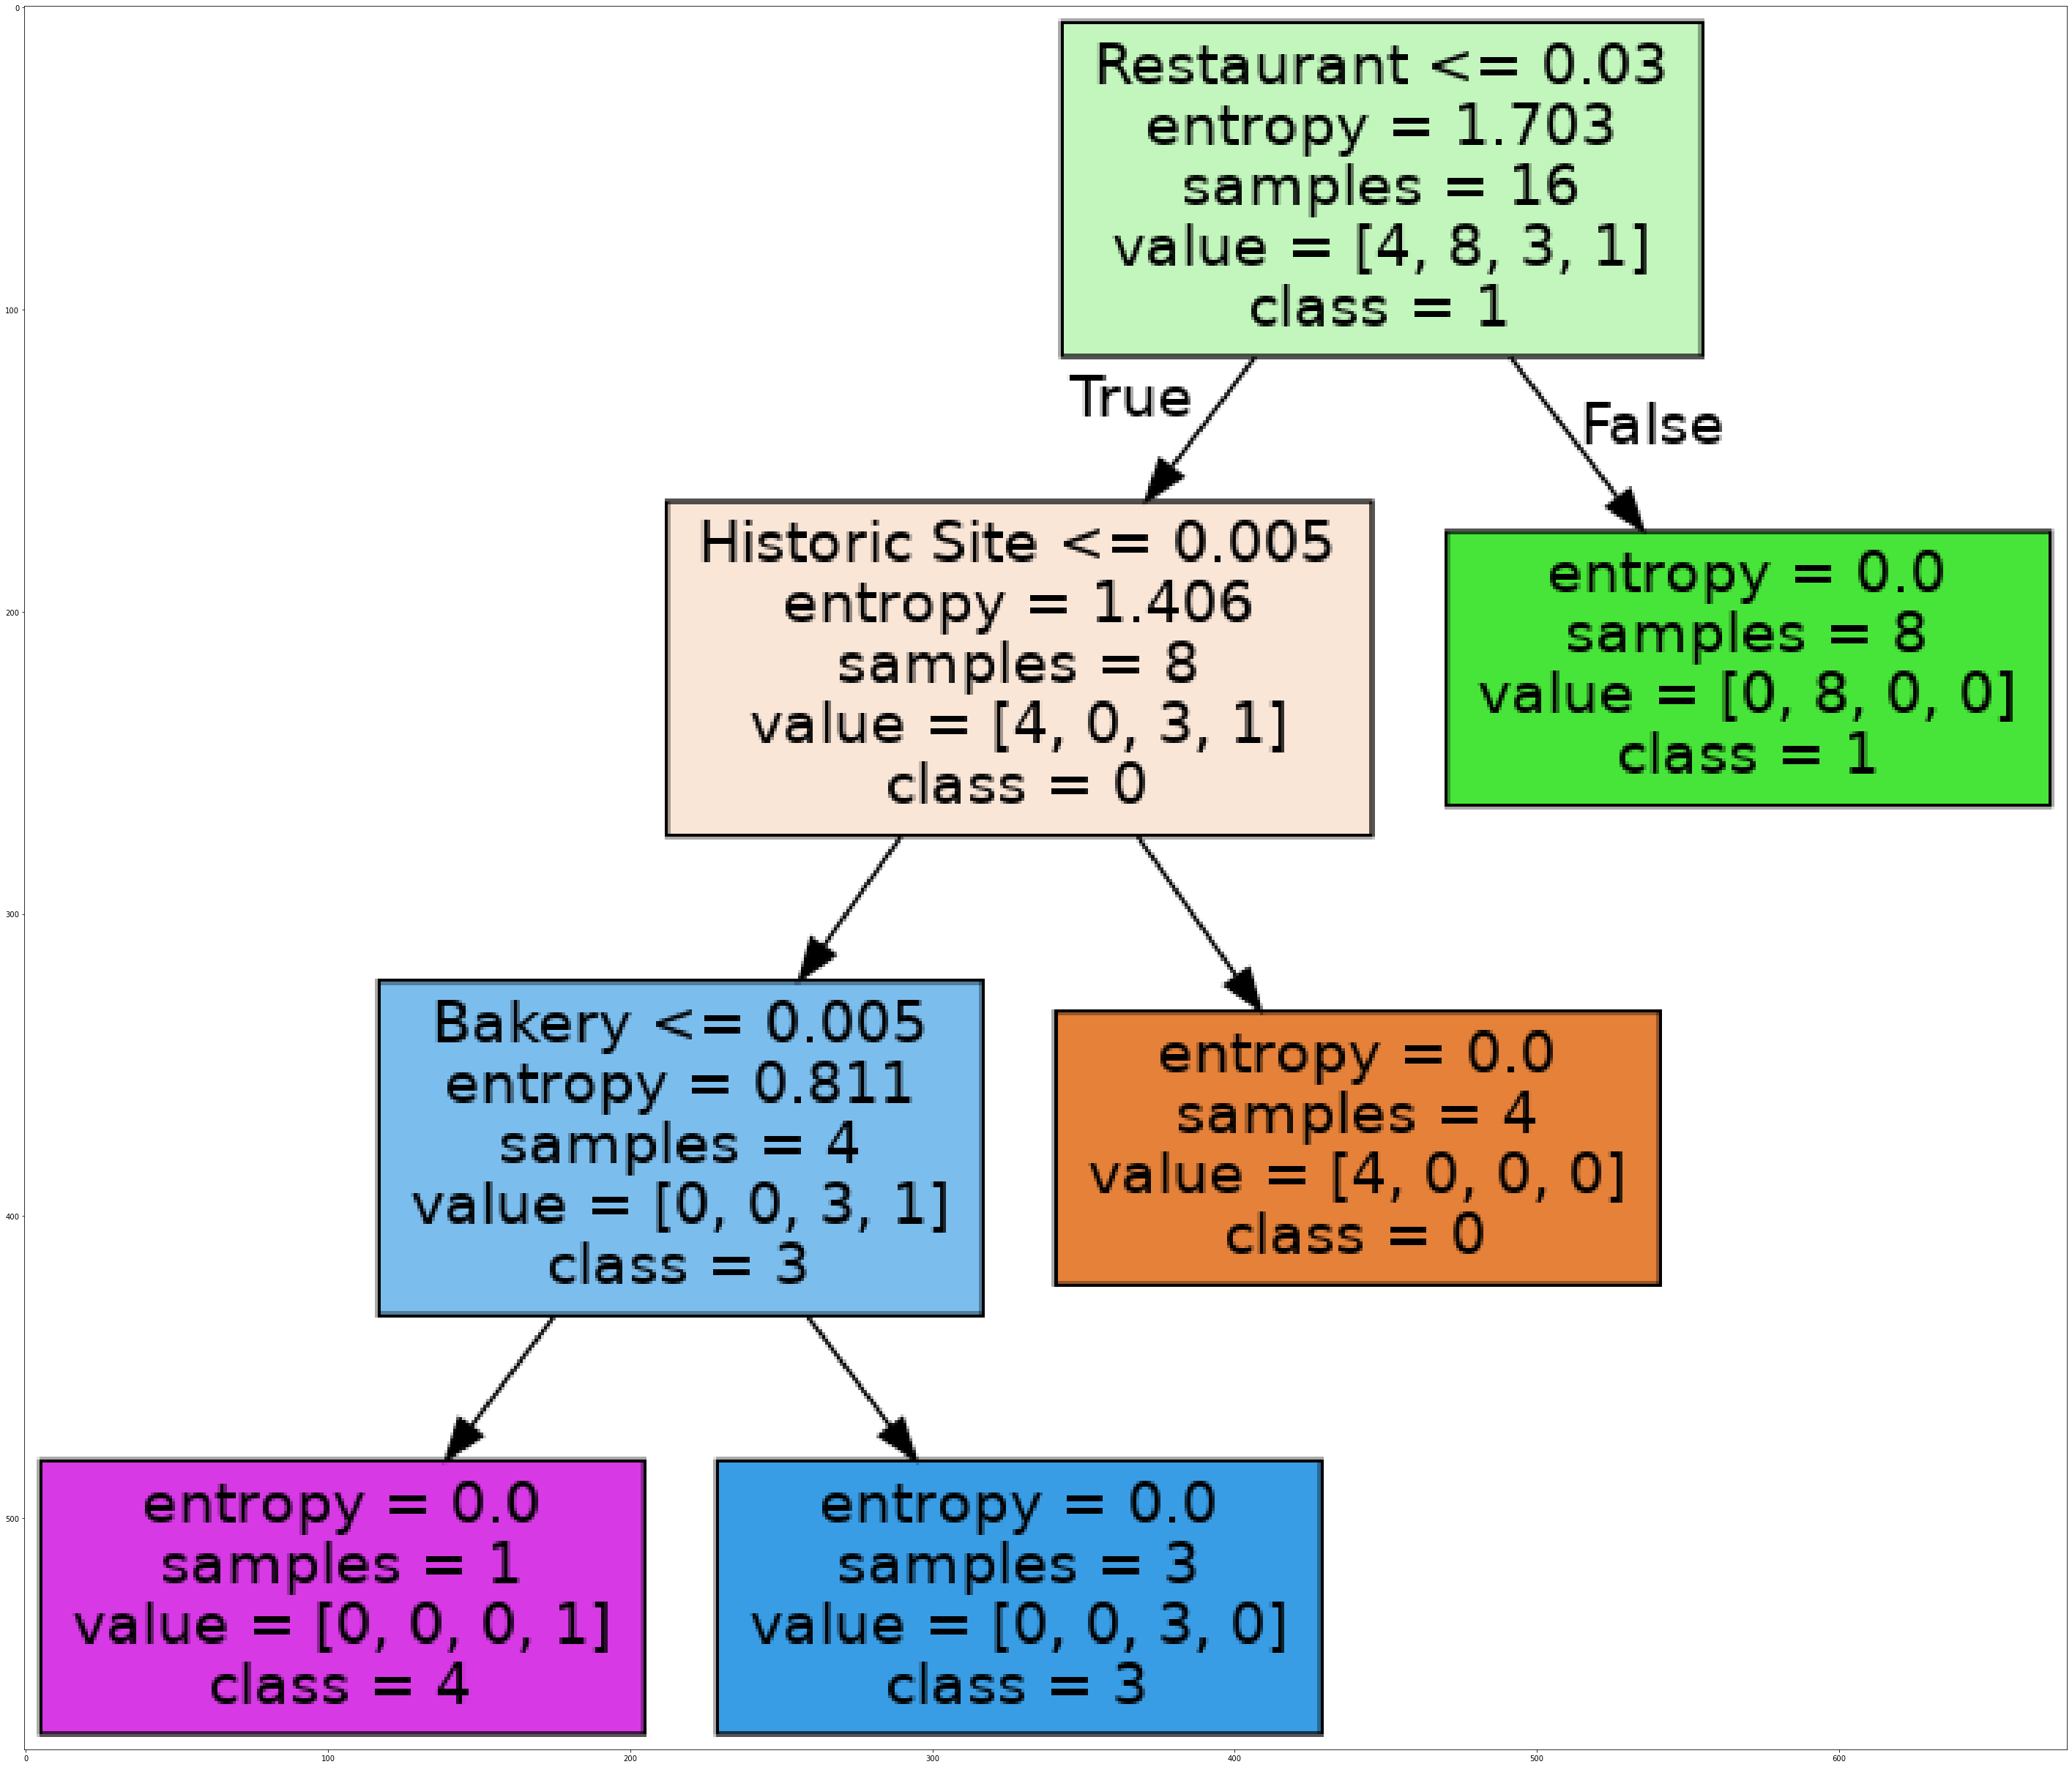

In [77]:
dot_data = StringIO()
filename = "clustertree.png"
featureNames = dt_onehot_p.columns[2:]
targetNames = str(dt_onehot_p["Cluster Labels"].unique())

out=tree.export_graphviz(cTree,feature_names=featureNames, out_file=dot_data, class_names= ['0','1','3','4'], filled=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(50,100))
plt.imshow(img,interpolation='nearest')

## Results and Discussion

Analysis shows that Mexico City was predicted to belong to cluster 4. Cluster 4 only includes the neighbourhoods of Rosedale.

In other workds, there is a similarity of facilities between in Mexico City and Rosedale neighbourhood. From this point on, mexicans from mexico City will be able to adapt quickly and well when they move to these area mentioned above.


## Conclusion

Purpose of this project was to reveal which neighbourhood in Downtown Toronto is most similar to Mexico City, in order to aid stakeholders the search for optimal location for the best immigration destination. Based on data from Foursquare API, I clustered and classified the areas. And it showed calculated best place.

The final decision on choosing the optial location will be made by stakeholders based on the characteristics(included in this project or not) of the region. This project will be a good reference for them.